# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Шаг 1. Посмотрим на файл с данными и изучим общую информацию. 

In [1]:
import pandas as pd
df = pd.read_csv('real_estate_data.csv', sep='\t', decimal=',')
display(df.head())


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.7,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   total_images          23699 non-null  int64 
 1   last_price            23699 non-null  object
 2   total_area            23699 non-null  object
 3   first_day_exposition  23699 non-null  object
 4   rooms                 23699 non-null  int64 
 5   ceiling_height        14504 non-null  object
 6   floors_total          23613 non-null  object
 7   living_area           21796 non-null  object
 8   floor                 23699 non-null  int64 
 9   is_apartment          2775 non-null   object
 10  studio                23699 non-null  bool  
 11  open_plan             23699 non-null  bool  
 12  kitchen_area          21421 non-null  object
 13  balcony               12180 non-null  object
 14  locality_name         23650 non-null  object
 15  airports_nearest      18157 non-null

In [3]:
df.isna().sum() #пропуски

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

# Вывод
1. В таблице 23699 строк и 22 столбца (это много), но уверен, что большая их часть нам не понадобится для решения задачи, хотя посмотрим) 
2. Есть пропуски, пока не понятно, что с ними делать, дальше разберемся!
3. Много столбцов, значения которых по факту числовые, но тип данных - object, т.е. строка, надо перевести их в int64, чтобы можно было выполнять с ними мат. операции
4. 2 столбца с типом данных bool, их можно перевести в тип object, для четкости :)
5. Столбец 'first_day_exposition' с датой и временем, надо перевести в нормальный временной формат


### Шаг 2. Предобработка данных

In [4]:
# 1. вручную изменим название столбца 'cityCenters_nearest'

df.columns = ['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition']

# 2. Заменим формат значений в столбце с датой и временем на временной формат 
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')


In [5]:
# 3. Избавимся от пропусков в данных, которые заполнялись вручную:
#    3.1 высота потолков. Есть один выброс 100м, не думаю, что он сильно повлияет на ср.значение, но все же, сравним с медианой. Пропусков много, но их можно смело менять на ср.з или медиану, т.к. высота потолков - это параметр который имеет очень небольшой разброс.
#print(df['ceiling_height'].value_counts())
df['ceiling_height'] = pd.to_numeric(df['ceiling_height'], errors='coerce') #заменим тип, чтобы можно было делать расчеты
#print(df['ceiling_height'].mean())
#print(df['ceiling_height'].median())
df['ceiling_height'] = df['ceiling_height'].fillna(2.77) # заменим пропуски на ср.значение
#    3.2 общая площадь. Пропусков мало, меняем на ср.з или медиану
#print(df['living_area'].value_counts())
df['living_area'] = pd.to_numeric(df['living_area'], errors='coerce')
#print(df['living_area'].mean())
#print(df['living_area'].median())
df['living_area'] = df['living_area'].fillna(34.45) # заменим пропуски на ср.значение
#    3.3 площадь кухни. Пропусков мало, меняем на ср.з или медиану
#print(df['kitchen_area'].value_counts())
df['kitchen_area'] = pd.to_numeric(df['kitchen_area'], errors='coerce')
#print(df['kitchen_area'].mean())
#print(df['kitchen_area'].median())
df['kitchen_area'] = df['kitchen_area'].fillna(10.56) # заменим пропуски на ср.значение
#    3.4 количество балконов. Заменим пропуски на 
#print(df['balcony'].value_counts())
df['balcony'] = pd.to_numeric(df['balcony'], errors='coerce')
df['balcony'] = df['balcony'].fillna(0.0) # заменим пропуски на нули
#    3.5 количество этажей в доме. Пропусков совсем мало, заменим их на аналогичное значение в столбце "floor", так кол-во этажей в доме точно не будет меньше указанного этажа.
df['floors_total'] = pd.to_numeric(df['floors_total'], errors='coerce')
df['floors_total'] = df['floors_total'].fillna(df.query('floors_total == "NaN"')['floor']) # меняем пропуски на значения столбца floor в срезе с условием

# Из столбцов с "ручным вводом" и пропусками еще остались 2 столбца. Это - 'является ли недвижка - апартаментами' и название локации. 
# Что делать с апартаментами и зачем они вообще нужны я пока не знаю, поэтому оставлю, как есть), а в столбце с locality_name пропусков совсем мало
# поэтому там я тоже ничего менять не буду, тем более это столбец со строками и никакаие мат.операции мы с ним делать не будем

#df.info()

In [6]:
# Чтобы выполнять мат.операции с данными столбцов, заменим их типы данных на целочисленные. 
# Кроме first_day_exposition (время) и locality_name (строки)
df['last_price'] = pd.to_numeric(df['last_price'], errors='coerce')
df['last_price'] = df['last_price'].astype('int')
df['total_area'] = pd.to_numeric(df['total_area'], errors='coerce')
df['total_area'] = df['total_area'].astype('int')
df['ceiling_height'] = df['ceiling_height'].astype('int')
df['floors_total'] = df['floors_total'].astype('int')
df['living_area'] = df['living_area'].astype('int')
df['kitchen_area'] = df['kitchen_area'].astype('int')
df['balcony'] = df['balcony'].astype('int')

In [7]:
#все колонки, которые указывают на удаленность от чего-либо оставим без изменений, т.к. это данные, которые заполняются автоматом, 
#пока лучше их не трогать, если ничего не подгрузилось, то скорее всего удаленность очень большая
#df.query('airports_nearest == "NaN"') - действительно, это все пригород, а не СПБ и удаленность не подгрузилась
#df.query('city_centers_nearest == "NaN"') - действительно, это все пригород, а не СПБ и удаленность не подгрузилась
#изменим у них тип данных
df['airports_nearest'] = pd.to_numeric(df['airports_nearest'], errors='coerce')
df['city_centers_nearest'] = pd.to_numeric(df['city_centers_nearest'], errors='coerce')
df['parks_nearest'] = pd.to_numeric(df['parks_nearest'], errors='coerce')
df['ponds_nearest'] = pd.to_numeric(df['ponds_nearest'], errors='coerce')

#в колонках указывающих на кол-во парков и прудов в радиусе 3км, пропуски заменим на нули, скорее всего это будет верным
#если в систему ничего не подгрузилось, значит парков и прудов в этом радиусе нет
df['parks_around3000'] = pd.to_numeric(df['parks_around3000'], errors='coerce')
df['ponds_around3000'] = pd.to_numeric(df['ponds_around3000'], errors='coerce')
df['parks_around3000'] = df['parks_around3000'].fillna(0)
df['ponds_around3000'] = df['ponds_around3000'].fillna(0)
#пропуски в столбце days_exposition скорее всего указывают на то, что объект еще не снят с продажи, поэтому у него нет даты окончания
#оставим пропуски, но заменим тип данных
df['days_exposition'] = pd.to_numeric(df['days_exposition'], errors='coerce')

In [8]:
#df.info()

### ВЫВОД
1. В целом в столбцах, которые заполняются руками есть пропуски, которые сложно связать с какими либо ошибками выгрузки и вероятно, это просто человеческий фактор (случайные пропуски) и значения были просто не добавленны в таблицу, тем более, их относительно немного. К примеру, высота потолков, площадь кухни, общая площадь, кол-во этаже. Такие значения можно смело менять на ср.зн. или медиану и это не повлияет на наши выводы :) Кроме кол-ва этажей, здесь я поменял пропуски на соответствующий этаж в столбце "floor".
2. Пропуски в столбцах с количеством балконов и временем размещения, похожи на то, что они были добавлены специально, т.к. у некоторых объектов просто может не быть балконов и объявление еще не снято с размещения соответственно, т.е. пропуски в балконах можно смело заменить на нули, а пропуски во времени объявления оставить без изменений.
3. Есть столбцы, которые заполняются автоматически. Если посмотреть срезы по столбцу "удаленность до центра" с пустыми строками, то понятно, что это пригород и центр очень далеко (скорее всего система считает удаленность до центра СПБ). Здесь мы пропуски оставляем, аналогично мы оставляем пропуски и в столбцах, указывающих на удаленность до аэропорта, ближ. парка и ближ. водоёма!
4. Осталось разобраться только с двумя столбцами, кол-во парков и водоёмах в радиусе 3 км. Вероятнее всего, что система поставила пропуски там, где данных объектов в указанном радиусе просто нет, поэтому пропуски можно смело заменить на нули.
5. Что касается типов данных, то все столбцы с числами и типом данных object (строка) я заменил на тип данных float64, чтобы в дальнейшем можно было проводить с ними мат операции. А столбцы с данными float64 и без пропусков (значений NaN) заменил на тип данных int (узнал, что столбцы float64 + NaN, не очень хорошо перводятся в int :)), хотя аока и до конца не понимаю зачем, возможно надо было все переводить во float, помотрим дальше, что будет) 


### Шаг 3. Расчитаем и добавим новые столбцы

In [9]:
# 1. добавим столбец с ценой за кв.м.
df['meter_price'] = df['last_price'] / df['total_area']
# 2. столбец с датой публикации уже есть 'first_day_exposition'

# 3. добавим столбец с вариантом этажности "последний этаж" с помощью метода where
df['floor_group'] = df['floor'].where(df['floor'] != df['floors_total'], 'последний этаж') 
#добавим столбец с вариантом этажности "первый этаж" и "другое", напишем функцию:
def function(floor):
    if floor == 1:
        return 'первый этаж'
    if floor == 'последний этаж':
        return 'последний этаж'
    return 'другое'
#применим функцию к столбцу 'floor_house'
df['floor_group'] = df['floor_group'].apply(function)
#print(df[['floors_total','floor','floor_group']].head(30)) #Проверка
# 4. Добавим столбцы с отношением жилой площади и площади кухни к общей площади
df['living_ratio'] = df['living_area'] / df['total_area']
df['kitchen_ratio'] = df['kitchen_area'] / df['total_area']
#print(df[['total_area','living_area','living_ratio','kitchen_area','kitchen_ratio']].head(30)) #Проверка


### Шаг 4. Исследовательский анализ данных

### Изучим следующие параметры: площадь, цена, число комнат, высота потолков. Построим гистограммы для каждого параметра.

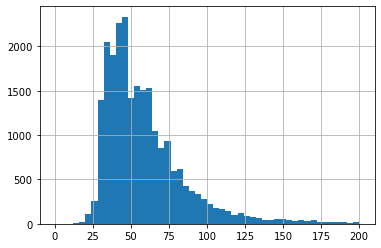

In [10]:
df['total_area'].hist(bins=50, range=(0, 200))

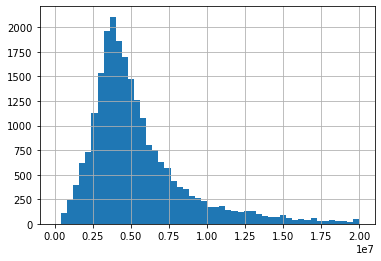

In [11]:
df['last_price'].hist(bins=50, range=(0,20000000))

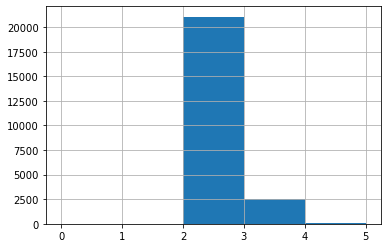

In [12]:
df['ceiling_height'].hist(bins=5, range=(0, 5))

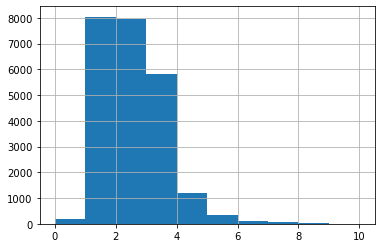

In [13]:
df['rooms'].hist(bins=10, range=(0, 10))

### Изучим время продажи недвижимости

180.88863436982163
95.0


count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

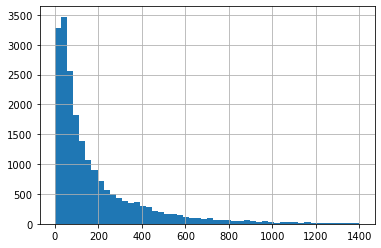

In [14]:
#Изучим время продажи недвижимости и ответим на вопросы:
#df['days_exposition'].value_counts()
df['days_exposition'].hist(bins=50, range=(0, 1400))
#Мы получили распределение Пуасона, а это значит, что "длинный хвост" скорее всего даст нам хорошую разницу между медианой и средним.
print(df['days_exposition'].mean())
print(df['days_exposition'].median())
df['days_exposition'].describe()
#да, действительно, среднее отличается от медианы почти в 2 раза.
# 1. Соответственно, среднее время, за которое продается недвижимость, можно считать 95 дней.
# 2. Из нашей гистограммы сразу видно, что время продажи доходит аж до 1400 дней, а это почти 4 года! (хотя max даже 1580 дней)
# да, это не 95 дней, за которые "улетела" половина квартир :) Вероятно это или очень дорогая недвижимость или не самая лучшая!
# 3. Если немного убавить range и поставить range=(0, 2), то будет видно, что одна квартира была снята с продажи уже через 1 день)
# думаю это можно считать быстрой продажей)



### Уберем редкие и выбивающиеся значения

count    19316.000000
mean       139.079882
std        136.861567
min          1.000000
25%         42.000000
50%         89.000000
75%        195.000000
max        599.000000
Name: days_exposition, dtype: float64

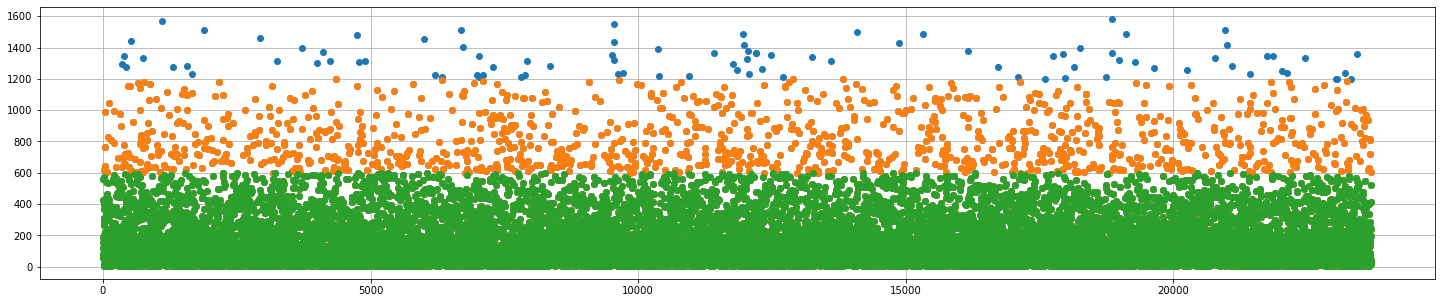

In [15]:

df['days_exposition'].plot(figsize=(25, 5), style='o', grid=True, alpha=1)
#попробуем убрать все значения более 1200 дней и посмотреть, как изменятся наши параметры
df.query('days_exposition < 1200')['days_exposition'].plot(figsize=(25, 5), style='o', grid=True, alpha=1)
df.query('days_exposition < 1200')['days_exposition'].describe()
#параметры почти не изменились, это означает, что выдающихся объектов настолько мало из всей нашей выборки, что они никак не влияют
#на наши выводы
#попробуем оставить только основную массу объвлений (визуально это примерно до 600 дней)
df.query('days_exposition < 600')['days_exposition'].plot(figsize=(25, 5), style='o', grid=True, alpha=1)
df.query('days_exposition < 600')['days_exposition'].describe()
#вот теперь среднее значение уже хорошо проседает, что вполне логично, когда мы откинули наш "длинный хвост",
#а медиана изменилась всего на 7%, что говорит, о том, что мы правильно взяли за среднее время продажи квартиры именно медиану в 95 дней.


In [16]:
#import matplotlib.pyplot as plt
#Для того, чтобы ответить на вопрос, как те или иные параметры влиют на стоимость, необходимо посчитать коэф-т корреляции Пирсона
#и для наглядности построить графики распределения
#создадим отдельную таблицу для этого исследования
df_corr = df[['last_price', 'total_area', 'rooms', 'floor_group', 'first_day_exposition', 'city_centers_nearest']]
#напишем функцию, которая поменяет значение в столбце floor_group на число, а то сравнивать число со строкой не очень получается :)
def func(floor_group):
    if floor_group == 'первый этаж':
        return 0
    if floor_group == 'последний этаж':
        return 1
    return 3
df_corr['floor_group_number'] = df_corr['floor_group'].apply(func)
print(df_corr.head())
df_corr.corr()
#pd.plotting.scatter_matrix(df_corr, figsize=(9, 9))


   last_price  total_area  rooms  floor_group first_day_exposition  \
0    13000000         108      3       другое           2019-03-07   
1     3350000          40      1  первый этаж           2018-12-04   
2     5196000          56      2       другое           2015-08-20   
3    64900000         159      3       другое           2015-07-24   
4    10000000         100      2       другое           2018-06-19   

   city_centers_nearest  floor_group_number  
0               16028.0                   3  
1               18603.0                   0  
2               13933.0                   3  
3                6800.0                   3  
4                8098.0                   3  


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,last_price,total_area,rooms,city_centers_nearest,floor_group_number
last_price,1.000000,0.653654,0.363343,-0.206747,0.033193
total_area,0.653654,1.000000,0.758347,-0.231466,0.002712
rooms,0.363343,0.758347,1.000000,-0.184864,-0.061785
city_centers_nearest,-0.206747,-0.231466,-0.184864,1.000000,-0.061071
floor_group_number,0.033193,0.002712,-0.061785,-0.061071,1.000000


Из данной таблицы можно сказать следующее:
1. Самый главный фактор, который влияет на рост цены (из изученных), это площадь недвижимости (КП = 0.653654), собственно это вполне логично и предсказуемо, здесь удивляться нечему)
2. Вроде как логично было предположить, что и кол-во комнат также будет оказывать сильное влияние на рост цены, но мы видим что КП = 0.363343, а это значит, что положительная корреляция имеет место быть, но она почти в 2 раза слабее, чем вышеуказанная. А это значит, что главное это общая площадь, и пусть в квартире будет хоть 10 комнат, если при этом площадь небольшая, то и цена тоже будет соответствующая. Корреляция положительная потому, что скорее всего с увеличением площади, растет и кол-во комнат
3. Корреляция цены и удаленности от центра отрицательная, а это значит, что с ростом цены уменьшается расстояния до центра. Или проще говоря, чем ближе к центру, тем дороже :) здесь тоже все предсказуемо и логично. Эти 2 параметра коррелируют слабее, чем 2 предыдущих.
4. И наконец самый слабый фактор, который практически СОВСЕМ не оказывает никакого влияния на стоимость недвижки - это группа этажности (0 - первый этаж, 1 - последний этаж, 3 - любой другой этаж)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbdf404c810>,
      dtype=object)

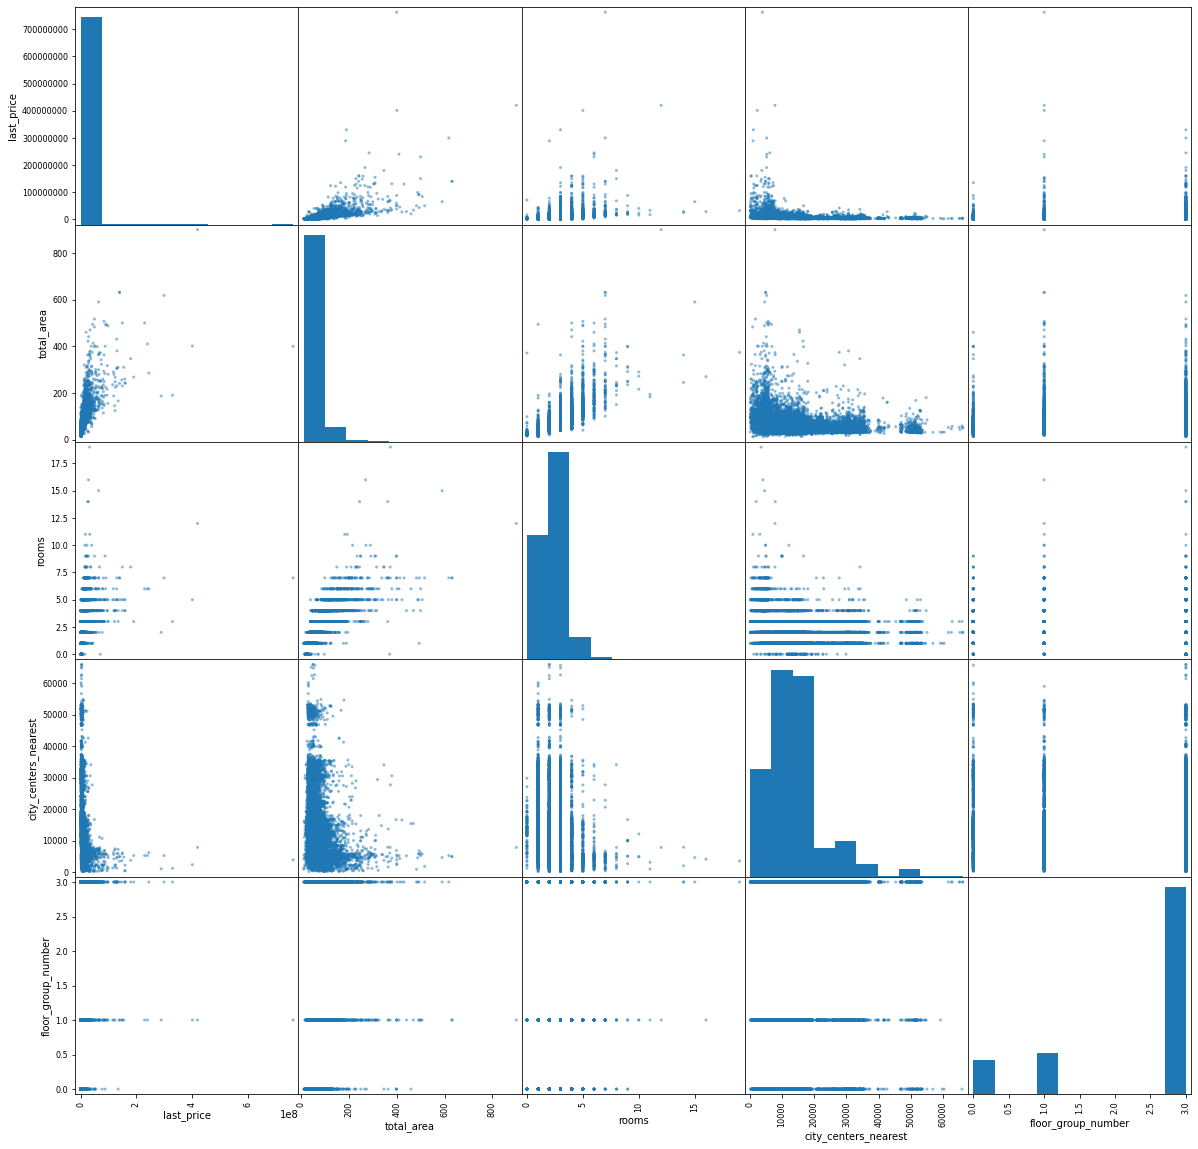

In [17]:
#теперь посмотрим на графики и посмотрим уже на данные визуально, т.к на наши коф-ты пирсона могли повлиять выбросы
pd.plotting.scatter_matrix(df_corr, figsize=(20, 20))


ВЫВОД
1. графики зависимости цены от площади и удаленности от центра выглядят весьма логично. Жирное пятно в диапазоне площади до 150 кв.м с динамикой на возрастание и большое пятно с удаленностью от центра не более 1-7 км, так же в этом диапазоне мы видим единичные выбросы недвижки с сумасшедшими ценниками), которых нет далее 10км от центра, что тоже похоже на правду
2. что касается этажности, то из графика уже можно заметить, что всё таки самый дешевый этаж является первым) здесь и выбросов даже нет)
3. В столбце с отношением кол-ва комнат и цены, если рассматривать основания столбцов (жирные точки), то можно заметить восходящую динамику, но также можно увидеть и пиковые столбцы в районе 3-5 комнат, т.е. видно, что недвижка с 10ю комнатами может стоить дешевли, чем трешка). Возможно здесь дело в ремонте и "древности", 3шка с дорогим ремонтом, может стоить дороже, чем 8-комнатная квартира пушкинских времен.

In [18]:
# Установим зависимость цены от даты публикации (года, месяца и дня)
df['year'] = pd.DatetimeIndex(df['first_day_exposition']).year
df['month'] = pd.DatetimeIndex(df['first_day_exposition']).month
df['day'] = pd.DatetimeIndex(df['first_day_exposition']).day

df.date = df[['last_price','year','month','day',]]
df.date.corr()
#сходу можно сказать, что дата вообще не влияет на стоимость, относительно месяца и дня, год оказывает влияние, но в целом оно ничтожное.
#попробуем найти и убрать выбросы и сделать расчет еще раз.
#df.date['last_price'].plot(figsize=(25, 5), style='o', grid=True, alpha=1)
#уберем все значения с ценой более 10 млн. это прям точно выбросы)
df.date.query('last_price < 10000000').corr()



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


,last_price,year,month,day
last_price,1.000000,0.005372,0.002511,0.002662
year,0.005372,1.000000,-0.265011,-0.024629
month,0.002511,-0.265011,1.000000,-0.021749
day,0.002662,-0.024629,-0.021749,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbdec203e50>,
      dtype=object)

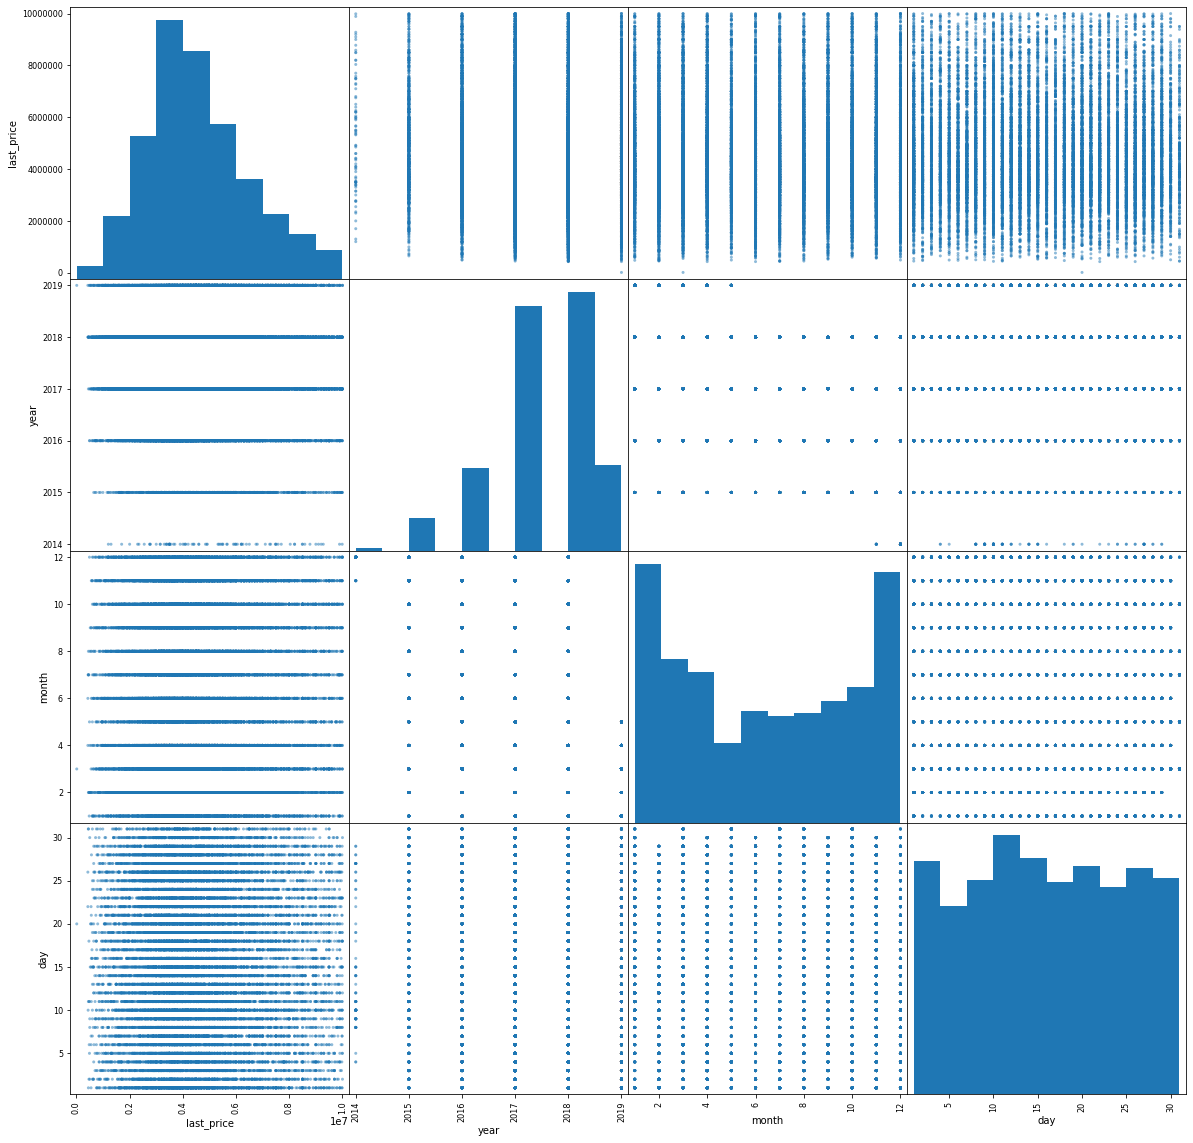

In [19]:
pd.plotting.scatter_matrix(df.date.query('last_price < 10000000'), figsize=(20, 20))

снова никакой корреляции, абсолютно ровные графики, единственное, что можно заметить, это то, что объектов на продвжу значительно
меньше в 2014 году, а далее в разы больше, возможно это как-то связано с кризисом, хотя распределение цен далее сохраняется таким же, может год взят не полный просто
короче говоря, исследование показало, что время не влияет на стоимость жилья

In [20]:
#Найдем ТОП-10 населенных пунктов по кол-ву объявлений и найдем для них ср. цену за кв.м.
#df['locality_name'].value_counts() # всего 364 локаций
#сгруппируем таблицу по поселкам, посчитаем среднюю цену за кв.м  и кол-во
df_meter = df.pivot_table(index='locality_name', values='meter_price', aggfunc=['mean','count'])
df_meter.columns = ['meter_price_mean','locality_count'] #заменим названия столбцов
df_meter = df_meter.sort_values('locality_count', ascending=False)# отсортируем по убыванию кол-ва объявлений
#print(df_meter.head(10)) #выведем ТОП-10
print(df_meter.head(10).query('meter_price_mean == meter_price_mean.min()'))
print(df_meter.head(10).query('meter_price_mean == meter_price_mean.max()'))


               meter_price_mean  locality_count
locality_name                                  
Выборг              58296.11948             237
                 meter_price_mean  locality_count
locality_name                                    
Санкт-Петербург     115347.722976           15721


1. Самый дорогой оказался Питер - 115к за кв.м, ну тут ничего странного нет)
2. А самый дешевый квадрат в Выборге - 58к, выгоднее всего приобретать жильё там)

                         last_price
city_centers_nearest_km            
0.0                        17900000
1.0                        11490000
2.0                        10000000
3.0                         8409000
4.0                         9200000
...                             ...
61.0                        3200000
62.0                        3200000
63.0                        3600000
65.0                        3475000
66.0                        4000000

[61 rows x 1 columns]


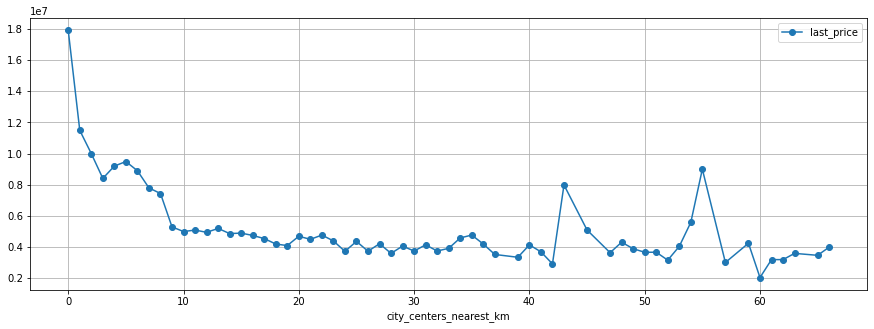

In [21]:
#Создадим столбец с удаленностью от центра в км. и округлим его значения до целых
df['city_centers_nearest_km'] = round(df['city_centers_nearest'] / 1000)
#df['city_centers_nearest_km'].value_counts() #всего 61 диапазон
df_km = df.pivot_table(index='city_centers_nearest_km', values='last_price', aggfunc='median')
df_km.plot(figsize=(15, 5), style='o-', grid=True, alpha=1)
print(df_km)




1. Резкое преломление с "устаканиванием" цены на уровне 3-5 млн. идет после 8 км от центра. Т.е. центром можно считать область с радиусом в 8 км.

In [22]:
#Далее проведем исследование на завосимость цены недвижки в центре от разлтчных параметров.
df_center = df.query('city_centers_nearest_km <= 8') #сделаем срез центр города
df_center_1 = df_center[['last_price', 'total_area', 'rooms', 'ceiling_height']]
df_center_2 = df_center[['last_price','rooms', 'floor_group', 'city_centers_nearest_km']]
df_center_2['floor_group_number'] = df_center_2['floor_group'].apply(func)
df_center_3 = df_center[['last_price','year', 'month', 'day']]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbdf4341590>]],
      dtype=object)

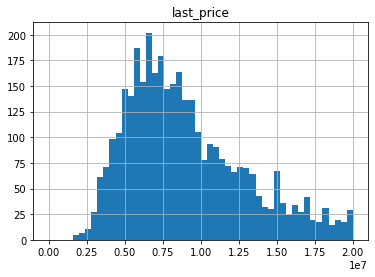

In [23]:
#Построим гистограммы для визуального представления данных
df_center_1.hist('last_price', bins=50, range=(0, 20000000))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbde3c57090>]],
      dtype=object)

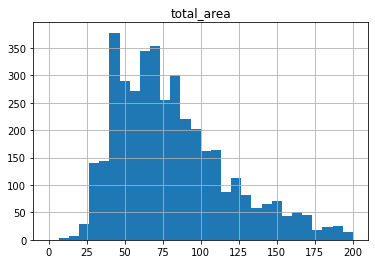

In [24]:
df_center_1.hist('total_area', bins=30, range=(0, 200))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbde3232b10>]],
      dtype=object)

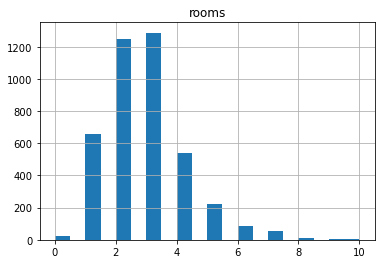

In [25]:
df_center_1.hist('rooms', bins=20, range=(0, 10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbde31bb150>]],
      dtype=object)

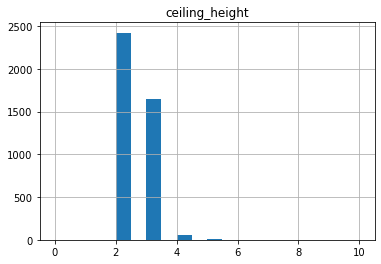

In [26]:
df_center_1.hist('ceiling_height', bins=20, range=(0, 10))

Квартиры в центре преимущественно:
1. Стоят от 5 до 10 млн.
2. Имеют площадь от 40 до 80 кв.м.
3. Это 2-3 комнатные квартиры с высотой потолков от 2,3 метра

In [27]:
# Теперь проведем исследование, как зависит цена от различных параметров
#посмотрим выбросы цены в центре
#df_center_2['last_price'].plot(figsize=(15, 5), style='o', grid=True, alpha=1)
# уберем ценники дороже 10 млн.
df_center_2.query('last_price < 10000000').corr()

,last_price,rooms,city_centers_nearest_km,floor_group_number
last_price,1.000000,0.462678,-0.209867,0.157856
rooms,0.462678,1.000000,-0.205097,-0.035670
city_centers_nearest_km,-0.209867,-0.205097,1.000000,0.127508
floor_group_number,0.157856,-0.035670,0.127508,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbdf4205a10>,
      dtype=object)

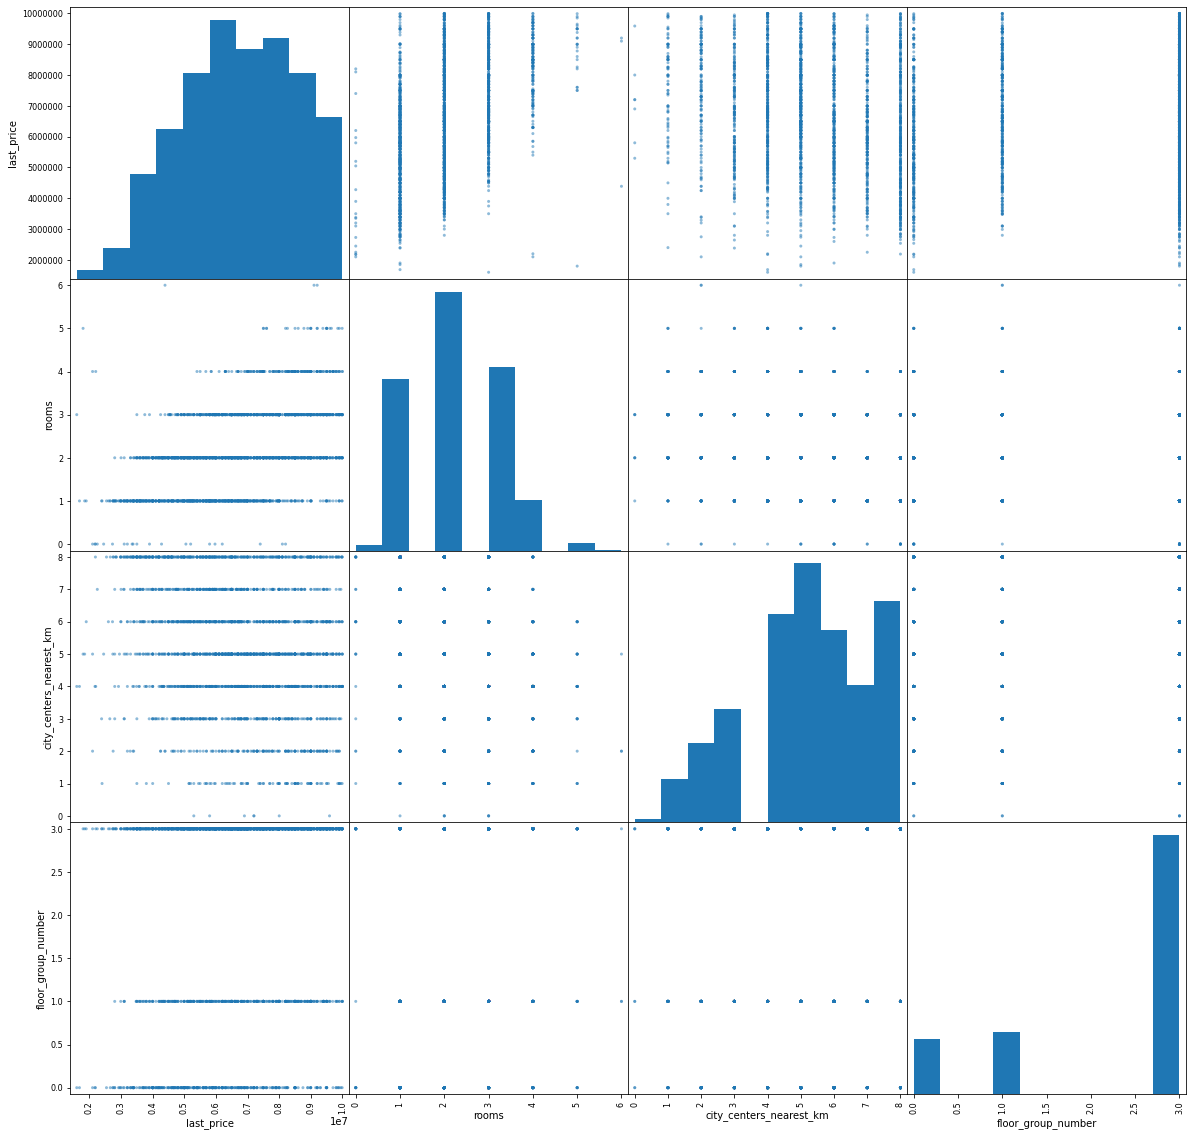

In [28]:
pd.plotting.scatter_matrix(df_center_2.query('last_price < 10000000'), figsize=(20, 20))

Что здесь можно увидеть:
1. Цена зависит от кол-ва комнат, чем их больше, тем дороже квартира
2. Совсем слабенькая корреляция стоимости и этажности, хотя на графике видно, что первый и последний этажи имеют варианты с более низкой ценой
3. Корреляция цены и удаленности отрицательная и график нам это подтверждает, чем дальше от самого центра, тем больше появляется объектов с более низкой ценой

In [29]:
df_center_3.query('last_price < 10000000').corr()

,last_price,year,month,day
last_price,1.00000,-0.016130,-0.014970,-0.008660
year,-0.01613,1.000000,-0.216652,-0.033476
month,-0.01497,-0.216652,1.000000,-0.033146
day,-0.00866,-0.033476,-0.033146,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbdec093e50>,
      dtype=object)

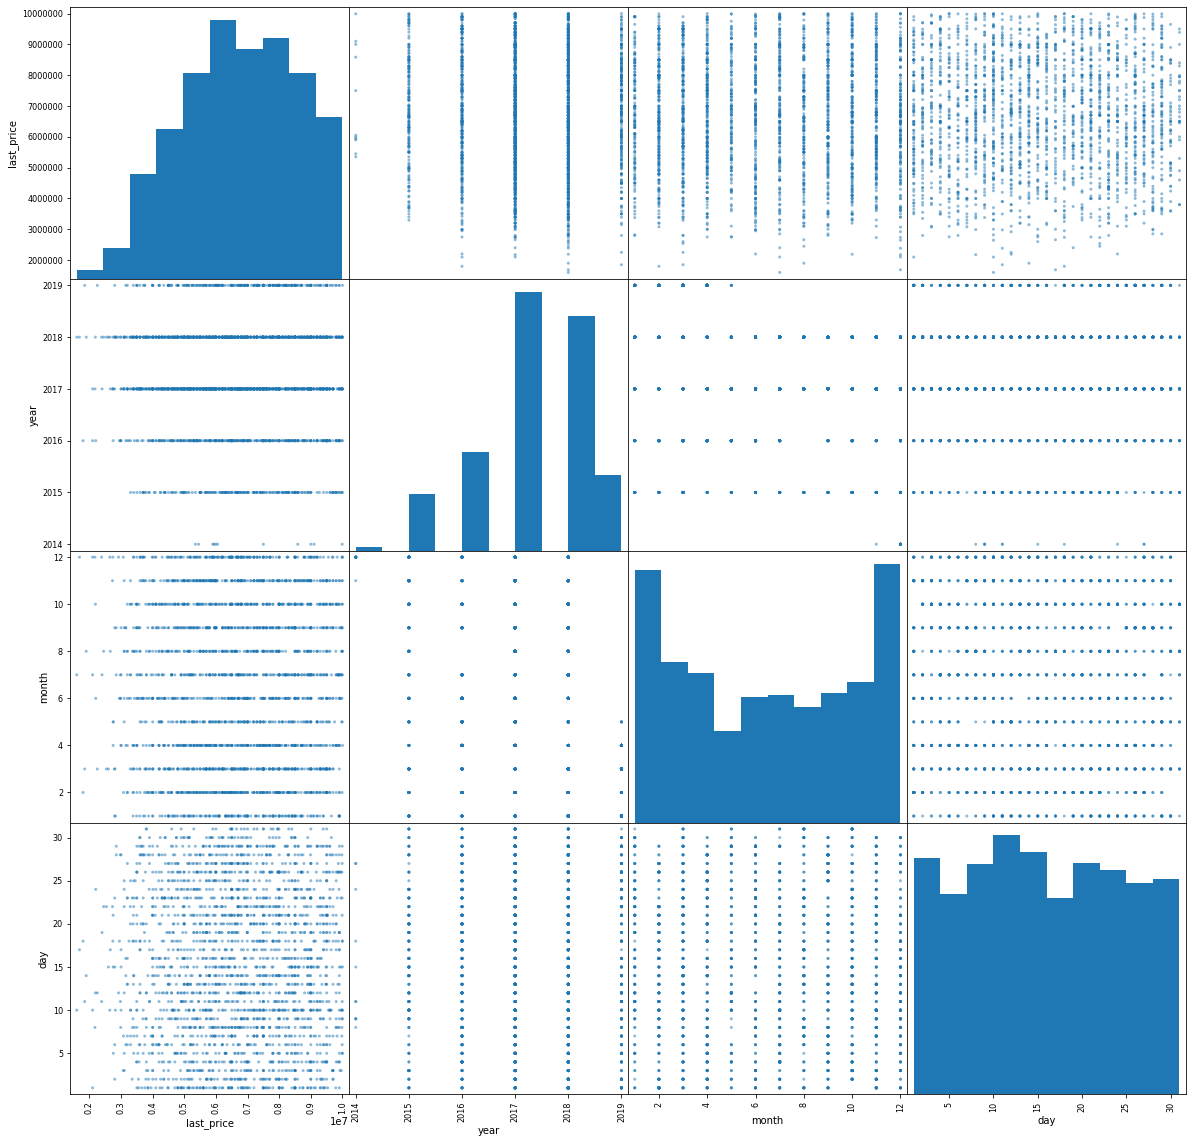

In [30]:
pd.plotting.scatter_matrix(df_center_3.query('last_price < 10000000'), figsize=(20, 20))

1. Корреляция цены от дат нулевая, единственное, что можно увидеть на графике, это то, что после 15 года, в центре появляется больше недорогих объектов ценой до 3,5 млн.

ВЫВОД
1.  В принципе каких-то серьезных отличий в исследовании (зависимости цены от комнат, удаленности, этажности и даты) всей недвижки от недвижки только в центре я не нашел, но заметил, что:
- Зависимость цены от кол-ва комнат сильнее в центре, чем в общем по всем объектам
- В обоих случаях дешевле недвижка на 1-м и последнем этаже
- Удаленность влияет на цену также в обоих случаях, корреляция отрицательная, т.е. с увеличением расстояния, уменьшается стоимость
- Время размещения также не влияет на цену в обоих исследованиях. Единственный момент, что в целом после 14 года появилось больше объектов на продажу, а после 15-го начало появляться больше более дешевых объектов в центре.


### Шаг 5. Общий вывод
Точно можно сказать, что стоимость недвижимости, зависит от двух главных параметров:
1. Удаленность от центра и общая площадь. Чем больше площадь, тем дороже недвижка, чем больше удаленность от центра, чем дешевле квартира. Это кажется логичным и понятным, но теперь у нас есть проработанное исследование и локументальное подтверждение этих очевидных вещей:)
2. Также мы установили, что 1 и последний этажи являются самыми дешевыми, а точнее, объявлений с недорогими квартирами гораздо больше на этих этажах (особенно наглядно нам это показывает график недвижимости в центре)
3. Дата размещения не влияет на стоимость недвижимости, по крайней мере с 15 по 19 год никакой закономерности нет, ни в центре, ни в целом
4. Кол-во комнат влияет на рост цены в центре, скорее всего это связано просто с увеличением площади. А вот если смотреть по общей картине, то рост цены идет до 3-4 комнат, а далее падает, скорее всего это из-за влияния центра, мы установили, что там квартиры дороже и в основном это 2-3 комнатные квартиры. Поэтому на общем графике 10 комнатные квартиры в целом стоят дешевле, отсюда и менее слабая корреляция в общем исследовании.